In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import SearchingOptimalEnsembles.metadatasets.quicktune.metadataset as qmd
import SearchingOptimalEnsembles.metadatasets.scikit_learn.metadataset as slmd
try: 
    import SearchingOptimalEnsembles.metadatasets.tabrepo.metadataset as trmd
except ImportError:
    trmd = None
import SearchingOptimalEnsembles.metadatasets.nasbench201.metadataset as nbmd

from SearchingOptimalEnsembles.posthoc.neural_ensembler import NeuralEnsembler
from sklearn.metrics import f1_score

/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
DATA_DIR = "/work/dlclarge2/janowski-quicktune/predictions"
md_class = qmd.QuicktuneMetaDataset
metric_name = "error"
data_version = "micro"
task_id = 0

metadataset = md_class(
    data_dir=DATA_DIR, metric_name=metric_name, data_version=data_version
)
dataset_names = metadataset.get_dataset_names()

metadataset.set_state(dataset_names[task_id])


In [16]:
dropout_rate = 0.9
ne = NeuralEnsembler(metadataset=metadataset,
                        ne_add_y=True,
                        ne_use_context=True,
                        learning_rate=0.0001,
                        epochs=1000,
                        ne_reg_term_div=0.0,
                        ne_reg_term_norm=0.,
                        ne_num_layers=3,
                        ne_num_heads=1,
                        ne_context_size=256,
                        ne_hidden_dim=32,
                        ne_use_mask=True,
                        ne_eval_context_size=128,
                        ne_resume_from_checkpoint=False,
                        ne_unique_weights_per_function=False,
                        ne_dropout_rate=dropout_rate,
                        use_wandb=False,
                        ne_net_type="ffn")

X_obs = [i.item() for i in metadataset.hp_candidates_ids]

best_ensemble, best_metric = ne.sample(X_obs)
weights = ne.get_weights(X_obs)

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:430: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.7592649459838867 Div Loss -0.0018320404924452305 W: 0.00021646941604558378
Epoch 1 Loss 1.4757959842681885 Div Loss -0.0018320409581065178 W: 0.00021662763901986182
Epoch 2 Loss 1.4528640508651733 Div Loss -0.001832038164138794 W: 0.00021662852668669075
Epoch 3 Loss 1.2944276332855225 Div Loss -0.0018320403760299087 W: 0.00021679222118109465
Epoch 4 Loss 1.3433403968811035 Div Loss -0.0018320331582799554 W: 0.00021644025400746614
Epoch 5 Loss 1.718261480331421 Div Loss -0.0018320365343242884 W: 0.00021666314569301903
Epoch 6 Loss 1.6266400814056396 Div Loss -0.0018320363014936447 W: 0.00021691859001293778
Epoch 7 Loss 1.384753704071045 Div Loss -0.0018320382805541158 W: 0.00021680851932615042
Epoch 8 Loss 1.5217740535736084 Div Loss -0.0018320378148928285 W: 0.00021672080038115382
Epoch 9 Loss 1.7900562286376953 Div Loss -0.0018320368835702538 W: 0.00021689629647880793
Epoch 10 Loss 1.4878671169281006 Div Loss -0.0018320361850783229 W: 0.0002169342478737235
Epoch 11 Loss

In [17]:
weights.shape

torch.Size([1, 230, 160, 20])

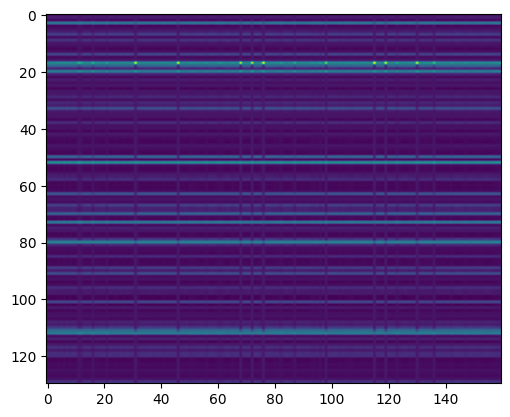

In [18]:
a = weights[0,100:,...,0]
plt.imshow((a-a.mean(0))/a.std(0))

In [19]:
predictions = metadataset.get_predictions([X_obs])
y_true = metadataset.get_targets().numpy()


In [20]:
f1_scores = []
for i in range(predictions.shape[1]):

    y_pred = predictions[0][i].argmax(-1).numpy()
    f1_scores.append(f1_score(y_true, y_pred, average=None))
f1_scores = np.array(f1_scores)


tensor(10)
tensor(14)
tensor(10)
tensor(9)
tensor(10)
tensor(12)
tensor(16)
tensor(14)
tensor(16)
tensor(13)
tensor(15)
tensor(9)
tensor(16)
tensor(9)
tensor(12)
tensor(10)
tensor(10)
tensor(7)
tensor(14)
tensor(9)


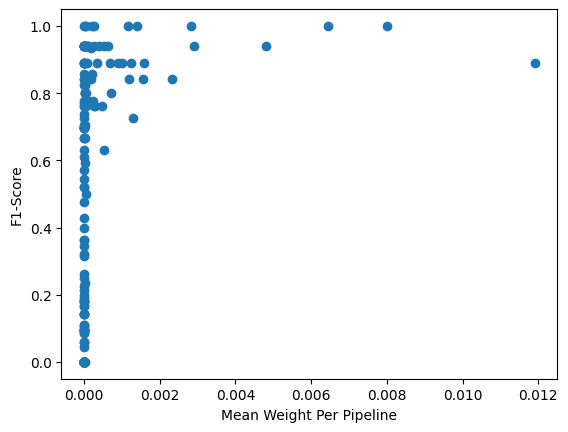

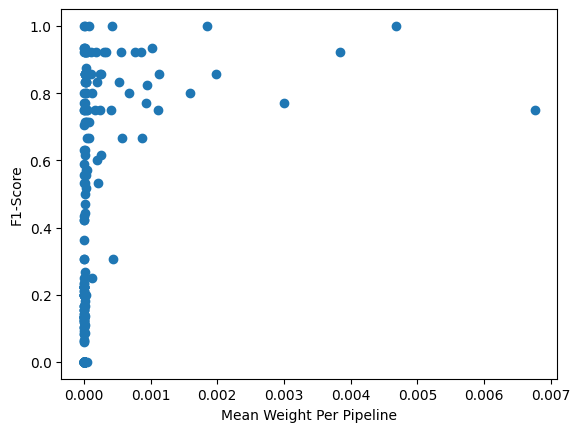

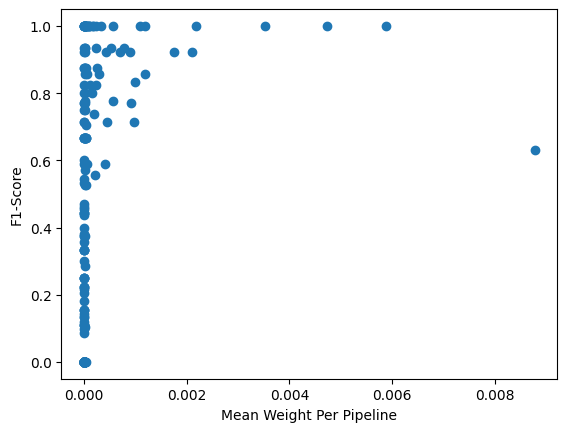

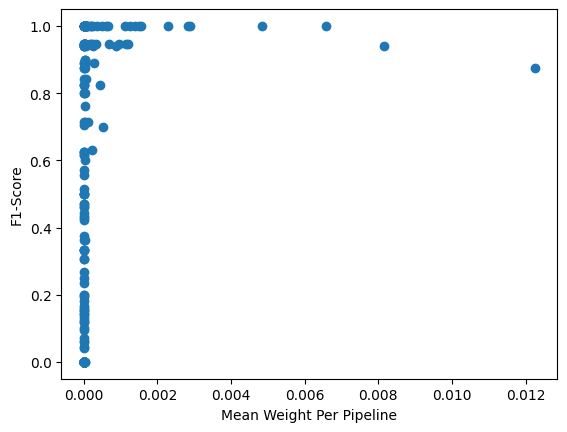

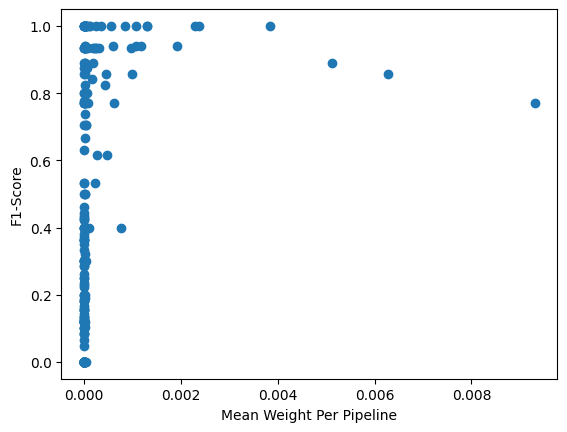

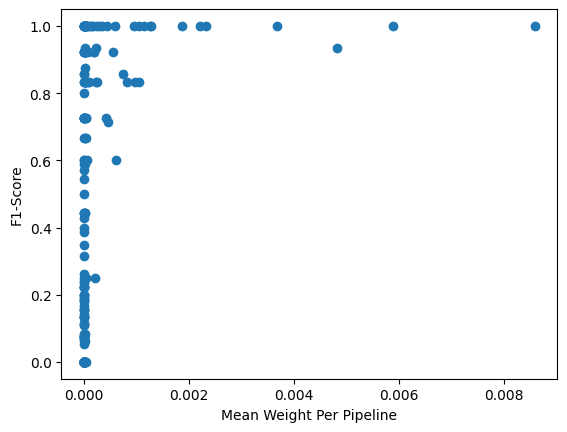

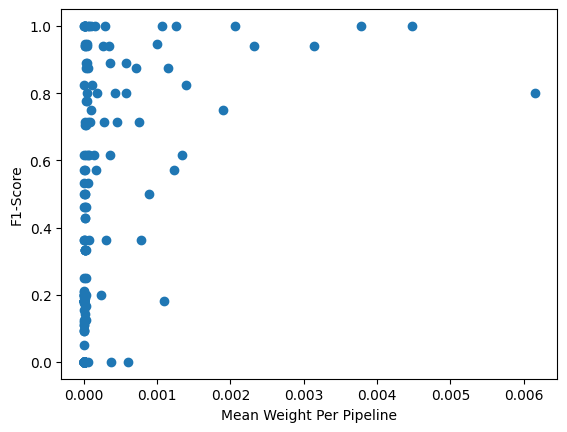

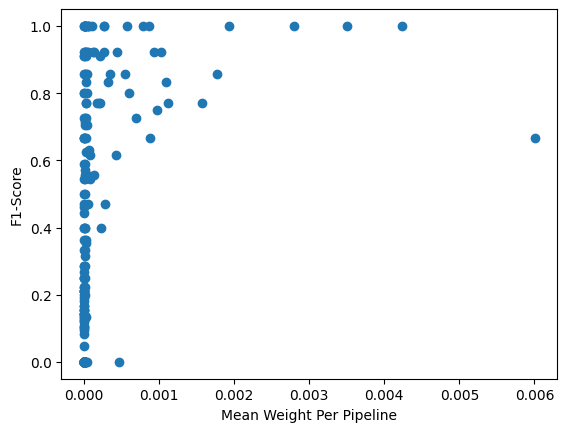

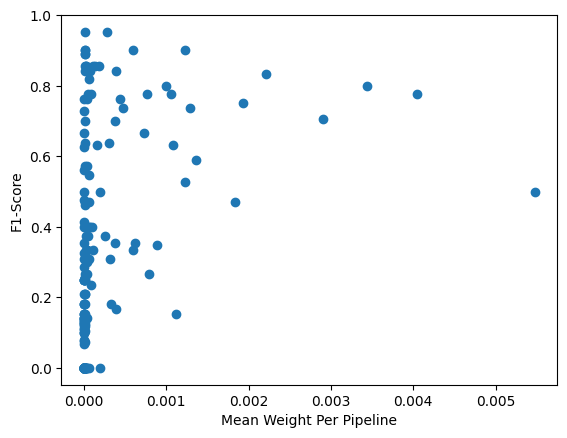

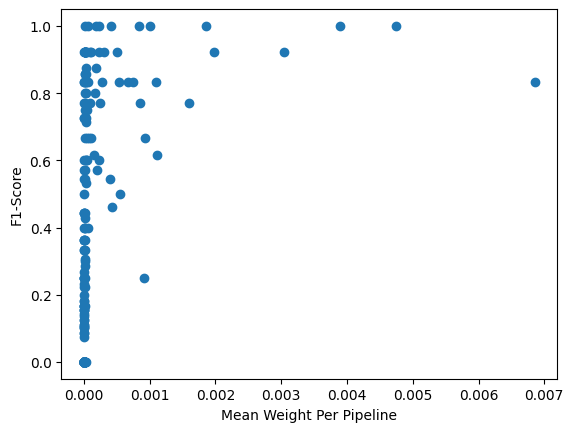

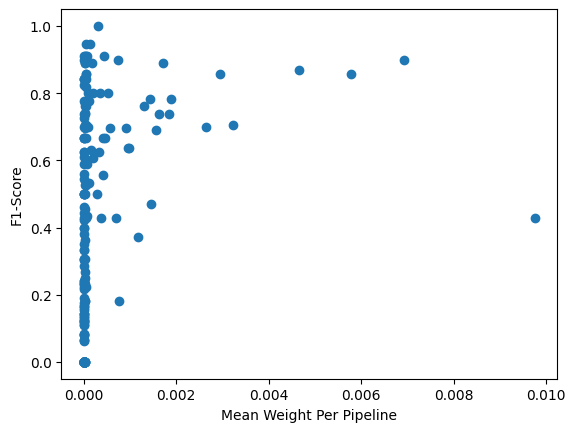

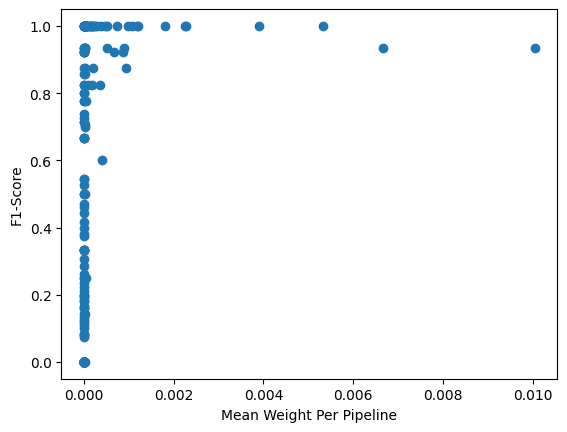

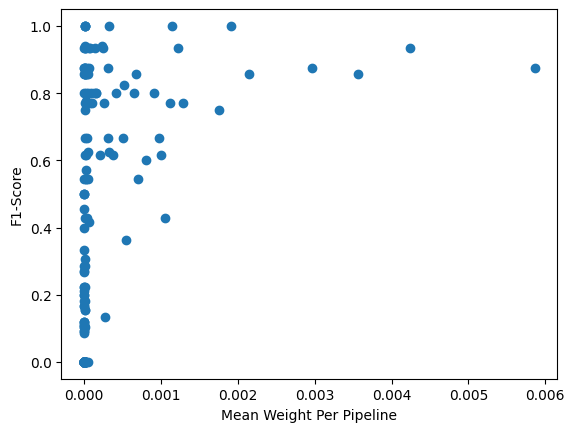

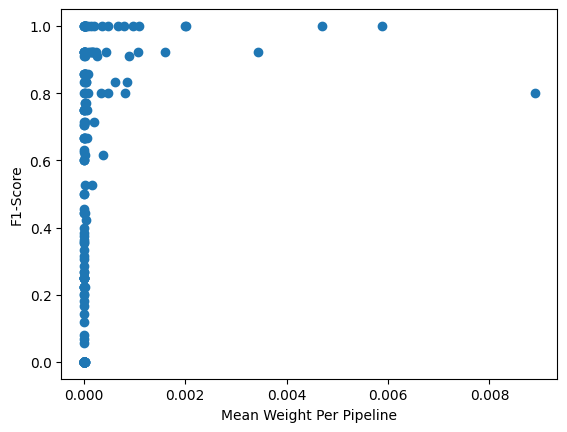

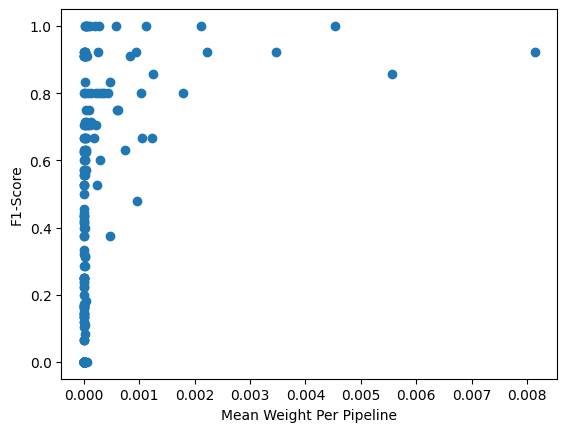

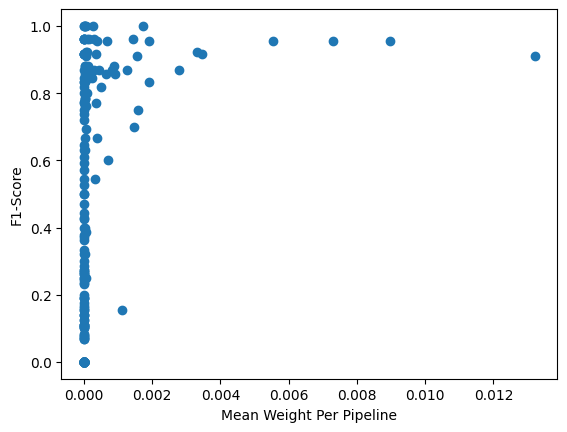

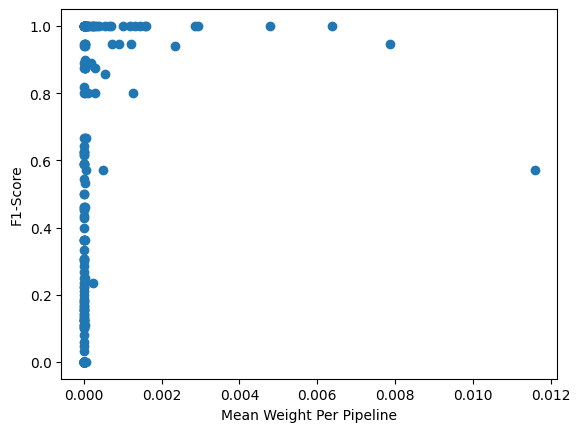

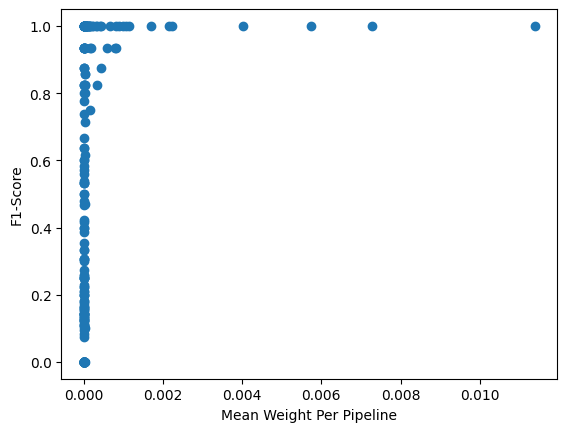

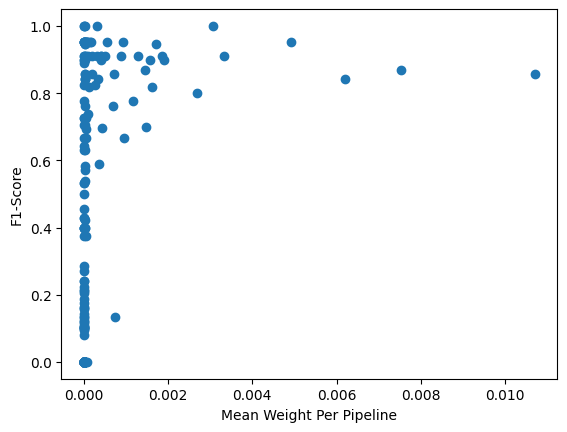

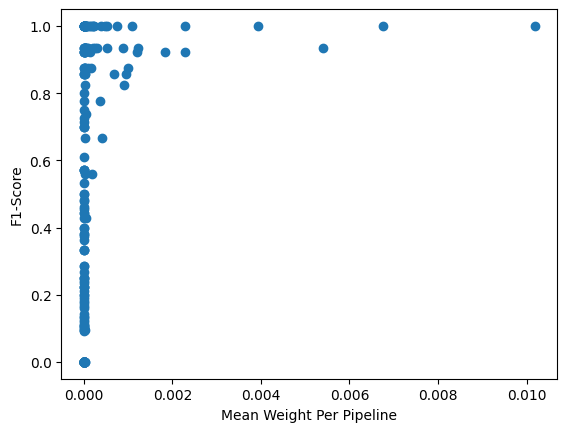

In [21]:

for i in range(f1_scores.shape[1]):
    x = weights[0].mean(axis=-2)[:,i]
    print(((x-x.mean())>x.std()).sum())
    plt.figure()
    plt.scatter(weights[0].mean(axis=-2)[:,i],f1_scores[:,i])
    plt.xlabel("Mean Weight Per Pipeline")
    plt.ylabel("F1-Score")

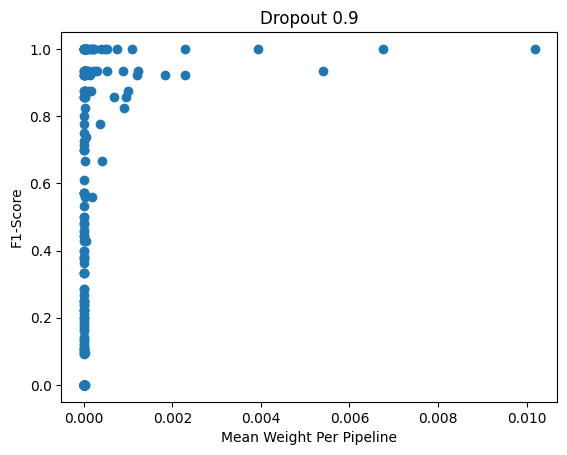

In [22]:
plt.scatter(weights[0].mean(axis=-2)[:,i],f1_scores[:,i])
plt.xlabel("Mean Weight Per Pipeline")
plt.ylabel("F1-Score")
plt.title(f"Dropout {dropout_rate}")
plt.savefig("saved_plots/hypothesis_overfitting4.png")

In [49]:
weights[0][...,i].shape

torch.Size([230, 160])

In [45]:
weights[0].shape

torch.Size([230, 160, 20])